In [ ]:
!pip install -qqq "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git" --progress-bar off
!pip install -qqq --no-deps "xformers<0.0.24" "trl<0.9.0" peft accelerate bitsandbytes --progress-bar off

In [ ]:
# Data Handling and Visualization
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# LLM model training
import torch
from trl import SFTTrainer
from transformers import TrainingArguments, TextStreamer
from unsloth.chat_templates import get_chat_template
from unsloth import FastLanguageModel, is_bfloat16_supported
from datasets import Dataset

# Saving model
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [ ]:
data = pd.read_json("hf://datasets/Amod/mental_health_counseling_conversations/combined_dataset.json", lines=True)

In [ ]:
data.head()

,Context,Response
0,I'm going through some things with my feelings...,"If everyone thinks you're worthless, then mayb..."
1,I'm going through some things with my feelings...,"Hello, and thank you for your question and see..."
2,I'm going through some things with my feelings...,First thing I'd suggest is getting the sleep y...
3,I'm going through some things with my feelings...,Therapy is essential for those that are feelin...
4,I'm going through some things with my feelings...,I first want to let you know that you are not ...


#### Length of data

In [ ]:
print('lenght of data is', len(data))

lenght of data is 3512


#### Shape of data

In [ ]:
data.shape

(3512, 2)

#### Checking Null values

In [ ]:
np.sum(data.isnull().any(axis=1))

0

#### Rows and columns in the dataset

In [ ]:
print('Count of columns in the data is:  ', len(data.columns))

Count of columns in the data is:   2


In [ ]:
print('Count of rows in the data is:  ', len(data))

Count of rows in the data is:   3512


#### Lets check the lenght of words in each context

In [ ]:
filtered_data = data[data['Context_length'] <= 1500]

In [ ]:
filtered_data = filtered_data[ln_Response <= 4000]

<div style="background-color: #f9f9f9; border-left: 6px solid #4CAF50; padding: 10px; margin: 20px 0;">
    <strong>Note:</strong> There is no need for such data preparation to handle the lengths of text for LLM models, but for consistency in the number of words, I just took under 4000 words as example so you can do any data preprocessing as per needs.
</div>


<h2 style="font-family: Arial, sans-serif; color: #4CAF50; border-bottom: 2px solid #4CAF50; padding-bottom: 5px; margin-bottom: 20px;">
   Model training 🧪
</h2>

<img src="https://miro.medium.com/v2/resize:fit:1400/1*mjbBdZ1-p7cKQkp-bU7aCg.gif">


[Image Reference](https://miro.medium.com/v2/resize:fit:1400/1*mjbBdZ1-p7cKQkp-bU7aCg.gif)


> Lets deep dive into Llama 3.1 model and train it on our data

### Loading the model

<div style="background-color: #f2f2f2; border-left: 5px solid #4CAF50; padding: 15px; margin: 20px 0;"> We are going to use Llama 3.1 with 8 billion parameters, but you can use the 70 billion version as well. However, you cannot use the 405 billion parameter version yet with Unsloth because it doesn't support it yet. When support for the 405 billion version is available, you will be able to use it by simply replacing the number!
</div>

<h3 style="color: #388e3c; font-family: Arial, sans-serif;">Key aspects which can be followed as per your requirement as well:</h3>

<ol style="margin-left: 20px;">
    <li><strong>Max Sequence Length:</strong>
        <p>We used <code>max_seq_length</code> 5020, the maximum number of tokens can be used in model that can handle in a single input sequence. This is crucial for tasks requiring the processing of long texts, ensuring that the model can capture more context in each pass. It can be used as per requirements.</p>
    </li>
    <li><strong>Loading Llama 3.1 Model:</strong>
        <p>The model and tokenizer are loaded using <code>FastLanguageModel.from_pretrained</code> with a specific pre-trained model, <code>"unsloth/Meta-Llama-3.1-8B-bnb-4bit"</code>. This is optimized for 4-bit precision, which reduces memory usage and increases training speed without significantly compromising performance. The <code>load_in_4bit=True</code> parameter enables this efficient 4-bit quantization, making it more suitable for fine-tuning on less powerful hardware.</p>
    </li>
    <li><strong>Applying PEFT (Parameter-Efficient Fine-Tuning):</strong>
        <p>Then we configured model using <code>get_peft_model</code>, which applies LoRA (Low-Rank Adaptation) techniques. This approach focuses on fine-tuning only specific layers or parts of the model, rather than the entire network, drastically reducing the computational resources needed.</p>
        <p>Parameters such as <code>r=16</code> and <code>lora_alpha=16</code> adjust the complexity and scaling of these adaptations. The use of <code>target_modules</code> specifies which layers of the model should be adapted, which include key components involved in attention mechanisms like <code>q_proj</code>, <code>k_proj</code>, and <code>v_proj</code>.</p>
        <p><code>use_rslora=True</code> activates Rank-Stabilized LoRA, which improves the stability of the fine-tuning process. <code>use_gradient_checkpointing="unsloth"</code> ensures that memory usage is optimized during training by selectively storing only necessary computations, further enhancing the model's efficiency.</p>
    </li>
    <li><strong>Verifying Trainable Parameters:</strong>
        <p>Finally we are using <code>model.print_trainable_parameters()</code> to print out the number of parameters that will be updated during fine-tuning, allowing to verify that only the intended parts of the model are being trained.</p>
    </li>
</ol>

<p>This combination of techniques makes the fine-tuning process not only more efficient but also more accessible, allowing you to deploy this model even with limited computational resources.</p>

> Setting maximum lenght of tokenz 5020 is more than enough as Low-Rank Adaptation (LoRA) for training but you can use as per your data and requirements.

In [ ]:
max_seq_length = 5020
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/Meta-Llama-3.1-8B-bnb-4bit",
    max_seq_length=max_seq_length,
    load_in_4bit=True,
    dtype=None,
)

model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    lora_alpha=16,
    lora_dropout=0,
    target_modules=["q_proj", "k_proj", "v_proj", "up_proj", "down_proj", "o_proj", "gate_proj"],
    use_rslora=True,
    use_gradient_checkpointing="unsloth"
)
print(model.print_trainable_parameters())

==((====))==  Unsloth 2024.8: Fast Llama patching. Transformers = 4.44.1.

   \\   /|    GPU: NVIDIA H100 NVL. Max memory: 93.003 GB. Platform = Linux.

O^O/ \_/ \    Pytorch: 2.1.1. CUDA = 9.0. CUDA Toolkit = 12.1.

\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.23.post1. FA2 = False]

 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Unsloth 2024.8 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


trainable params: 41,943,040 || all params: 8,072,204,288 || trainable%: 0.5196

None


### Prapare data for model feed

<div style="background-color: #f2f2f2; border-left: 5px solid #4CAF50; padding: 15px; margin: 20px 0;"> Now its time to design format prompt for mental health analysis. This function analyzes the input text from a psychological perspective, identifying indicators of emotional distress, coping mechanisms, or overall mental well-being. It also highlights potential concerns or positive aspects, providing brief explanations for each observation. We are going to prepare this data for further processing by the model, ensuring that each input-output pair is clearly formatted for effective analysis.
</div>

<h3 style="color: #388e3c; font-family: Arial, sans-serif;">Main points to remember:</h3>

<ol style="margin-left: 20px;">
    <li><strong>Data Prompt Structure:</strong>
        <p>The <code>data_prompt</code> is a formatted string template designed to guide the model in analyzing the provided text. It includes placeholders for the input text (the context) and the model's response. This template specifically prompts the model to identify mental health indicators, making it easier to fine-tune the model for mental health-related tasks.</p>
    </li>
    <li><strong>End-of-Sequence Token:</strong>
        <p>The <code>EOS_TOKEN</code> is retrieved from the tokenizer to signify the end of each text sequence. This token is essential for the model to recognize when a prompt has ended, helping to maintain the structure of the data during training or inference.</p>
    </li>
    <li><strong>Formatting Function:</strong>
        <p>The <code>formatting_prompt</code> used to take a batch of examples and formats them according to the <code>data_prompt</code>. It iterates over the input and output pairs, inserting them into the template and appending the EOS token at the end. The function then returns a dictionary containing the formatted text, ready for model training or evaluation.</p>
    </li>
    <li><strong>Function Output:</strong>
        <p>The function outputs a dictionary where the key is <code>"text"</code> and the value is a list of formatted strings. Each string represents a fully prepared prompt for the model, combining the context, response and the structured prompt template.</p>
    </li>
</ol>

In [ ]:
data_prompt = """Analyze the provided text from a mental health perspective. Identify any indicators of emotional distress, coping mechanisms, or psychological well-being. Highlight any potential concerns or positive aspects related to mental health, and provide a brief explanation for each observation.

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token
def formatting_prompt(examples):
    inputs       = examples["Context"]
    outputs      = examples["Response"]
    texts = []
    for input_, output in zip(inputs, outputs):
        text = data_prompt.format(input_, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }

### Format the data for training

In [ ]:
training_data = Dataset.from_pandas(filtered_data)
training_data = training_data.map(formatting_prompt, batched=True)

### Model training with custom parameters and data

> <p style="font-size: 14px; color: #333;">
        Using <code>sudo apt-get update</code> to refresh the list of available packages and <code>sudo apt-get install build-essential</code> to install essential tools. Only run this on shell if you get any error.
    </p>


In [ ]:
#sudo apt-get update
#sudo apt-get install build-essential

<h3 style="color: #388e3c; font-family: Arial, sans-serif;">Training setup to start fine tuning!</h3>

<ol style="margin-left: 20px;">
    <li><strong>Trainer Initialization:</strong>
        <p>We are going to initialize <code>SFTTrainer</code> with the model and tokenizer, as well as the training dataset. The <code>dataset_text_field</code> parameter specifies the field in the dataset that contains the text to be used for training which we prepared above. The trainer is responsible for managing the fine-tuning process, including data handling and model updates.</p>
    </li>
    <li><strong>Training Arguments:</strong>
        <p>The <code>TrainingArguments</code> class is used to define key hyperparameters for the training process. These include:</p>
        <ul>
            <li><code>learning_rate=3e-4</code>: Sets the learning rate for the optimizer.</li>
            <li><code>per_device_train_batch_size=32</code>: Defines the batch size per device, optimizing GPU usage.</li>
            <li><code>num_train_epochs=20</code>: Specifies the number of training epochs.</li>
            <li><code>fp16=not is_bfloat16_supported()</code> and <code>bf16=is_bfloat16_supported()</code>: Enable mixed precision training to reduce memory usage, depending on hardware support.</li>
            <li><code>optim="adamw_8bit"</code>: Uses the 8-bit AdamW optimizer for efficient memory usage.</li>
            <li><code>weight_decay=0.01</code>: Applies weight decay to prevent overfitting.</li>
            <li><code>output_dir="output"</code>: Specifies the directory where the trained model and logs will be saved.</li>
        </ul>
    </li>
    <li><strong>Training Process:</strong>
        <p>Finally we called <code>trainer.train()</code> method to start the training process. It uses the defined parameters of our fine-tune the model, adjusting weights and learning from the provided dataset. The trainer also handles data packing and gradient accumulation, optimizing the training pipeline for better performance.</p>
    </li>
</ol>

In [ ]:
trainer=SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=training_data,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    dataset_num_proc=2,
    packing=True,
    args=TrainingArguments(
        learning_rate=3e-4,
        lr_scheduler_type="linear",
        per_device_train_batch_size=32,
        gradient_accumulation_steps=4,
        num_train_epochs=20,
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        warmup_steps=10,
        output_dir="output",
        seed=0,
    ),
)

trainer.train()

Generating train split: 0 examples [00:00, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1

   \\   /|    Num examples = 593 | Num Epochs = 20

O^O/ \_/ \    Batch size per device = 32 | Gradient Accumulation steps = 4

\        /    Total batch size = 128 | Total steps = 80

 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,2.337100
2,2.130900
3,2.112800
4,2.045100
5,2.048000
6,1.936200
7,2.096400
8,1.974700
9,1.904400
10,1.892900


TrainOutput(global_step=80, training_loss=1.4284833692014218, metrics={'train_runtime': 3007.0031, 'train_samples_per_second': 3.944, 'train_steps_per_second': 0.027, 'total_flos': 9.2735910445056e+17, 'train_loss': 1.4284833692014218, 'epoch': 16.842105263157894})

## Inference

In [ ]:
text="I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here. I've never tried or contemplated suicide. I've always wanted to fix my issues, but I never get around to it. How can I change my feeling of being worthless to everyone?"

<div style="background-color: #f2f2f2; border-left: 5px solid #4CAF50; padding: 15px; margin: 20px 0;">
    <strong>Note:</strong> Lets use the fine-tuned model for inference in order to generate responses based on mental health-related prompts !
</div>

<h3 style="color: #388e3c; font-family: Arial, sans-serif;">Here is some keys to note:</h3>

<ol style="margin-left: 20px;">
        <p>The <code>model = FastLanguageModel.for_inference(model)</code> configures the model specifically for inference, optimizing its performance for generating responses.</p>
    </li>
        <p>The input text is tokenized using the <code>tokenizer</code>, it convert the text into a format that model can process. We are using <code>data_prompt</code> to format the input text, while the response placeholder is left empty to get response from model. The <code>return_tensors = "pt"</code> parameter specifies that the output should be in PyTorch tensors, which are then moved to the GPU using <code>.to("cuda")</code> for faster processing.</p>
    </li>
        <p>The <code>model.generate</code> method generating response based on the tokenized inputs. The parameters <code>max_new_tokens = 5020</code> and <code>use_cache = True</code> ensure that the model can produce long and coherent responses efficiently by utilizing cached computation from previous layers.</p>
    </li>
</ol>

In [ ]:
model = FastLanguageModel.for_inference(model)
inputs = tokenizer(
[
    data_prompt.format(
        #instructions
        text,
        #answer
        "",
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 5020, use_cache = True)
answer=tokenizer.batch_decode(outputs)
answer = answer[0].split("### Response:")[-1]
print("Answer of the question is:", answer)

Answer of the question is: 

Hi there, I want to acknowledge you for reaching out to ask for help. That's the first step! It sounds like you are experiencing some depression symptoms and it is important to seek help for them as they can worsen over time. You are not worthless and this thought is only a thought, it's not the truth. A professional counsellor can help you change negative thought patterns, build coping skills and learn to challenge negative thoughts. I recommend you to contact a professional counsellor, your family doctor or a crisis hot-line to discuss your symptoms. You are not alone and you can get help! Take care. Rosanne Bermudez, CCVP, RCCWS <|im_end|>


<div style="background-color: #f2f2f2; border-left: 5px solid #4CAF50; padding: 15px; margin: 20px 0;">   <strong>Note:</strong> Here is how we can securely push a fine-tuned model and its tokenizer to the Hugging Face Hub so any body can use it. It can be accessed on my account <strong><a href="https://huggingface.co/ImranzamanML/finetuned_llama3.1" target="_blank">ImranzamanML/finetuned_llama3.1</a></strong>
</div>


In [ ]:
os.environ["HF_TOKEN"] = "hugging face token key, you can create from your HF account."
model.push_to_hub("ImranzamanML/finetuned_llama3.1", use_auth_token=os.getenv("HF_TOKEN"))
tokenizer.push_to_hub("ImranzamanML/finetuned_llama3.1", use_auth_token=os.getenv("HF_TOKEN"))

README.md:   0%|          | 0.00/31.0 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

Saved model to https://huggingface.co/ImranzamanML/finetuned_llama3.1


<div style="background-color: #f2f2f2; border-left: 5px solid #4CAF50; padding: 15px; margin: 20px 0;">   <strong>Note:</strong> We can also save fine-tuned model and its tokenizer locally on the machine.
</div>


In [ ]:
model.save_pretrained("model/finetuned_llama3.1")
tokenizer.save_pretrained("model/finetuned_llama3.1")


        
<div style="background-color: #f2f2f2; border-left: 5px solid #4CAF50; padding: 15px; margin: 20px 0;"> Still 👀 for something?
</div>
Ok let me show you how you can load your saved model and use it!

<pre style="background-color: #e0f7fa; border: 1px solid #009688; padding: 10px; border-radius: 5px; font-family: Consolas, 'Courier New', monospace; font-size: 14px;">
model, tokenizer = FastLanguageModel.from_pretrained(
model_name = "model/finetuned_llama3.1",
max_seq_length = 5020,
dtype = None,
load_in_4bit = True)
</pre>


<p style="font-family: Comic Sans MS, cursive, sans-serif; color: #333; font-size: 16px;">
    No way, still searching for something? 😄 No worries! You can use the prompt format and code above to get response for mental peace 🧠✨
</p>


#### Happy to Connect 😊
<div style="background-color: #f9f9f9; border: 1px solid #ddd; padding: 20px; text-align: center; font-family: Arial, sans-serif;">
    <h3 style="margin-bottom: 20px;">Muhammad Imran Zaman</h3>
    <a href="https://www.kaggle.com/muhammadimran112233" style="text-decoration: none; margin-right: 20px;">
        <img src="https://www.kaggle.com/static/images/site-logo.svg" width="100" height="100" alt="Kaggle Profile">
    </a>
    <a href="https://www.linkedin.com/in/muhammad-imran-zaman" style="text-decoration: none; margin-right: 20px;">
        <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/ca/LinkedIn_logo_initials.png/600px-LinkedIn_logo_initials.png" width="50" height="50" alt="LinkedIn Profile">
    </a>
    <a href="https://scholar.google.com/citations?user=ulVFpy8AAAAJ&hl=en" style="text-decoration: none; margin-right: 20px;">
        <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/c7/Google_Scholar_logo.svg/768px-Google_Scholar_logo.svg.png" width="50" height="50" alt="Google Scholar Profile">
    </a>
    <a href="https://www.youtube.com/@consolioo" style="text-decoration: none; margin-right: 20px;">
        <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/72/YouTube_social_white_square_%282017%29.svg/640px-YouTube_social_white_square_%282017%29.svg.png" width="50" height="50" alt="YouTube Channel">
    </a>
    <a href="https://github.com/Imran-ml" style="text-decoration: none; margin-right: 20px;">
        <img src="https://github.githubassets.com/images/modules/logos_page/GitHub-Mark.png" width="50" height="50" alt="GitHub Profile">
    </a>
    <a href="https://imranzaman-5202.medium.com/" style="text-decoration: none; margin-right: 20px;">
        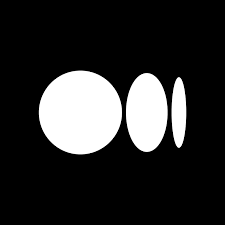
    </a>
    <a href="https://huggingface.co/ImranzamanML" style="text-decoration: none;">
        <img src="https://huggingface.co/datasets/huggingface/brand-assets/resolve/main/hf-logo-with-title.svg" width="200" height="100" alt="Hugging Face Profile">
    </a>
</div>
